In [1]:
#importing necessary libraries for the data manipulation and analysis 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize

#code for installing new libraries within the jupyter notebbok
"""import sys
!{sys.executable} -m pip install lmfit
"""
import lmfit
from lmfit.models import PolynomialModel,ExponentialModel,PowerLawModel,StepModel

### Create custom function to calculate various quantities 

The simulation outputs, enable the calculation of various parameters (such as Froude and Reynolds numbers) via data manipulation.

Below, i code a function called `var` that takes as input the simulation outputs, namely: 

* `df_ul` = superficial liquid velocity 
* `df_ug` = superficial liquid gas 
* `df_rhol` = liquid density
* `df_rhog` = gas density
* `df_mul` = liquid viscosity
* `df_mug` = gas viscosity

The function returns the following:

* `df_reynolds` = Reynolds number
* `df_froude` = Froude number
* `df_mum` = mixture's viscosity
* `df_um` = mixture's velocity
* `df_rhom` = mixture's density

for the respective CGR data file


This function (`var`) will automate the processing of data for each CGR spreadsheet.

In [2]:
def var(df_ul,df_ug, df_rhol,df_rhog,df_mul,df_mug):

    #u_mixture dataframe
    df_um=df_ul.iloc[:,1:]+df_ug.iloc[:,1:]
    df_um.insert(0, 'x', df_ul['x'])

    #rho_mixture dataframe
    df_rhom=df_rhol.iloc[:,1:]*df_ul.iloc[:,1:]+df_rhog.iloc[:,1:]*df_ug.iloc[:,1:]
    df_rhom.insert(0, 'x', df_ul['x'])
    
    #mu_mixture dataframe
    df_mum=df_mul.iloc[:,1:]*df_ul.iloc[:,1:]+df_mug.iloc[:,1:]*df_ug.iloc[:,1:]
    df_mum.insert(0, 'x', df_ul['x'])

    #Reynolds number dataframe 
    #This calculation causes a division by zero, which is problematic.
    df_reynolds=(df_um.iloc[:,1:]*df_rhom.iloc[:,1:]*0.324)/(0.001*df_mum.iloc[:,1:])
    df_reynolds.insert(0, 'x', df_ul['x'])
    #Any rows contining NULL as a result of division with zero will be dropped as they impact the regression later.
    df_reynolds.dropna(inplace=True)#drop null caused by division with zero
    df_reynolds.reset_index(inplace=True,drop=True) # reset index of the dataframe

    #Froude number dataframe 
    df_froude=df_um.iloc[:,1:]*((df_rhol.iloc[:,1:]/(df_rhol.iloc[:,1:]-df_rhog.iloc[:,1:])).apply(np.sqrt))*df_um.iloc[:,1:]/(np.sqrt(9.81*0.324))
    df_froude.insert(0, 'x', df_ul['x'])
    #drop first row of Froude dataframe as it contains all zeros and will affect the regression later
    df_froude.drop(df_froude.index[0], inplace=True)
    df_froude.reset_index(inplace=True,drop=True)
    
    return df_reynolds,df_froude,df_mum,df_rhom,df_um


Next we will import all the indivdual sheets within each CGR spreadsheet and use  `vars` to generate new parameters of interest

In [3]:
#CGR 100
cgr100 = pd.ExcelFile('Data_CGR100.xlsx') #specify the excel file
df_p100 = pd.read_excel(cgr100, 'pressure') #specify the sheet name within the excel file
df_rhol = pd.read_excel(cgr100, 'liquid density')
df_rhog = pd.read_excel(cgr100, 'gas density')
df_mul = pd.read_excel(cgr100, 'liquid viscosity')
df_mug = pd.read_excel(cgr100, 'gas viscosity')
df_ul100 = pd.read_excel(cgr100, 'liquid superficial velocity')
df_ul100=df_ul100.abs() #converting any negative values to absolute values 
df_ug100 = pd.read_excel(cgr100, 'gas superficial velocity')
df_reynolds100,df_froude100,df_mum100,df_rhom100,df_um100 = var(df_ul100,df_ug100, df_rhol,df_rhog,df_mul,df_mug)

#--------------

#CGR 500
cgr500 = pd.ExcelFile('Data_CGR500.xlsx')
df_p500 = pd.read_excel(cgr500, 'pressure')
df_rhol = pd.read_excel(cgr500, 'liquid density')
df_rhog = pd.read_excel(cgr500, 'gas density')
df_mul = pd.read_excel(cgr500, 'liquid viscosity')
df_mug = pd.read_excel(cgr500, 'gas viscosity')
df_ul500 = pd.read_excel(cgr500, 'liquid superficial velocity')
df_ul500=df_ul500.abs() #converting any negative values to absolute values
df_ug500 = pd.read_excel(cgr500, 'gas superficial velocity')
 
df_reynolds500,df_froude500,df_mum500,df_rhom500,df_um500 = var(df_ul500,df_ug500, df_rhol,df_rhog,df_mul,df_mug)

#-----------

#CGR 1000
cgr1000 = pd.ExcelFile('Data_CGR1000.xlsx')
df_p1000 = pd.read_excel(cgr1000, 'pressure')
df_rhol = pd.read_excel(cgr1000, 'liquid density')
df_rhog = pd.read_excel(cgr1000, 'gas density')
df_mul = pd.read_excel(cgr1000, 'liquid viscosity')
df_mug = pd.read_excel(cgr1000, 'gas viscosity')
df_ul1000 = pd.read_excel(cgr1000, 'liquid superficial velocity')
df_ul1000=df_ul1000.abs()#converting any negative values to absolute values
df_ug1000 = pd.read_excel(cgr1000, 'gas superficial velocity')
 
df_reynolds1000,df_froude1000,df_mum1000,df_rhom1000,df_um1000 = var(df_ul1000,df_ug1000, df_rhol,df_rhog,df_mul,df_mug)


### Create custom plot function

To familiarise with the data, i will create a custom plot function that generates subplots of variables (e.g. Reynolds, Froude, etc.) as
a function of the inlet gas rate. 

The simulation provides output at several locations along the pipeline (column `x` in the spreadsheets)- a total of 271 points.For conciseness we will take a subset of those data points to visualise the regression.

The `plot` function takes as input the following:

* `variable_list` - this list contains 3 different dataframes corresponding to different CGR

* `step` this is the sampling of the original dataset.  

* `nrow,ncol` define how many subplots are used for plotting.  


In [4]:
def plot(variable_list,step, nrow,ncol):
    
    # define a list of the different CGR for which the plots would be generates
    df_names= ['CGR 100','CGR 500','CGR 1000']
    
    #define characteristics of figure, axes and subplots
    fig, axes = plt.subplots(nrow, ncol,figsize=(20,15), sharex=True)

    count=0; # this counter is used as an ID for plotting below
    for r in range(nrow):
        for c in range(ncol):
            count+=1
            for df in range(3):
                variable_list[df].T.iloc[1:,::step].iloc[:,count].plot(ax=axes[c,r],label=df_names[df], style='o') #create a plot of the selected dataframe columns
                axes[c,r].set_title("x= "+str(round(variable_list[df].T.iloc[0:,::step].iloc[0,count],3)))
                axes[c,r].legend()
    plt.tight_layout()       
    plt.clf 
  

## Create function for regression

The `plot_reg` function takes the same input as the `plot` function, with an additional input, that specifies the type of function to be fitted:

Possible models include:
    `PolynomialModel()`,`ExponentialModel()`,`PowerLawModel()`,`StepModel()` (these models are from the `lmfit` library.
    
The `lmfit` library does not support logarithmic model fitting. In order to get around that, I used the `scipy.optimize` library to create a logarithmic regression function called `plot_logreg`.

In [5]:
def plot_reg(variable_list,step, nrow,ncol,model):
    x=[5,10,20,30,40,50,75,100,125] # xaxis datapoints (gas rate)

    # define a list of the different CGR for which the plots would be generates
    df_names= ['CGR 100','CGR 500','CGR 1000']
    
    #define characteristics of figure, axes and subplots
    fig, axes = plt.subplots(nrow, ncol,figsize=(20,15), sharex=True)

    count=0; # this counter is used as an ID for plotting below
    for r in range(nrow):
        for c in range(ncol):
            count+=1
            for df in range(3):
                params = model.guess(variable_list[df].T.iloc[1:,::step].iloc[:,count],x=x) #generate the fitting parameters
                result = model.fit(variable_list[df].T.iloc[1:,::step].iloc[:,count], params,x=x) #fit the model
                result.plot_fit(axes[c,r],xlabel=('Gas rate')) #plot the fitted model
                axes[c,r].set_title("x= "+str(round(variable_list[df].T.iloc[0:,::step].iloc[0,count],3)))
                axes[c,r].legend(['CGR 100','CGR100 fit','CGR 500','CGR500 fit','CGR 1000','CGR1000 fit'])
    plt.tight_layout()       
    plt.clf 

In [6]:
#logarithmic function fit using the Scipy library

def log_fit(x, a,b,c): 
    return a*np.log(b+x)+c
    
def plot_logreg(variable_list,step, nrow,ncol,log_fit):
    x=[5,10,20,30,40,50,75,100,125] # x-axis datapoints 

    # define a list of the different CGR for which the plots would be generates
    df_names= ['CGR 100','CGR 500','CGR 1000']

    #define characteristics of figure, axes and subplots
    axes = np.zeros(shape=(nrow,ncol))
    fig = plt.figure(figsize=(20,15))
    
    for df in range(3):
        for i, ax in enumerate(axes.flatten()):
            params,params_covariance = optimize.curve_fit(log_fit, x, variable_list[df].T.iloc[1:,::step].iloc[:,i]) #calculate fitting parameters
            ax = fig.add_subplot(nrow,ncol,i+1)
            plt.scatter(x, variable_list[df].T.iloc[1:,::step].iloc[:,i], label='Data') #plot raw data
            plt.plot(x, log_fit(x, params[0],params[1],params[2]),label='Fitted function')  #plot fitted function
            plt.legend(['CGR 100','CGR100 fit','CGR 500','CGR500 fit','CGR 1000','CGR1000 fit'],loc='best')
            ax.set_title("x= "+str(round(variable_list[df].T.iloc[0:,::step].iloc[0,i],3)))
    plt.tight_layout()       
    plt.clf 

We next generate the `variable_list` options, used as an input in the functions above.

In [7]:
#The following parameters are selected for plotting:

froude = [df_froude100 ,df_froude500, df_froude1000]
reynolds = [df_reynolds100 ,df_reynolds500, df_reynolds1000]
u_g = [df_ug100,df_ug500,df_ug1000]
u_l = [df_ul100,df_ul500,df_ul1000]
pressure = [df_p100,df_p500,df_p1000]

# Regression on Reynolds number 

## Polynomial 

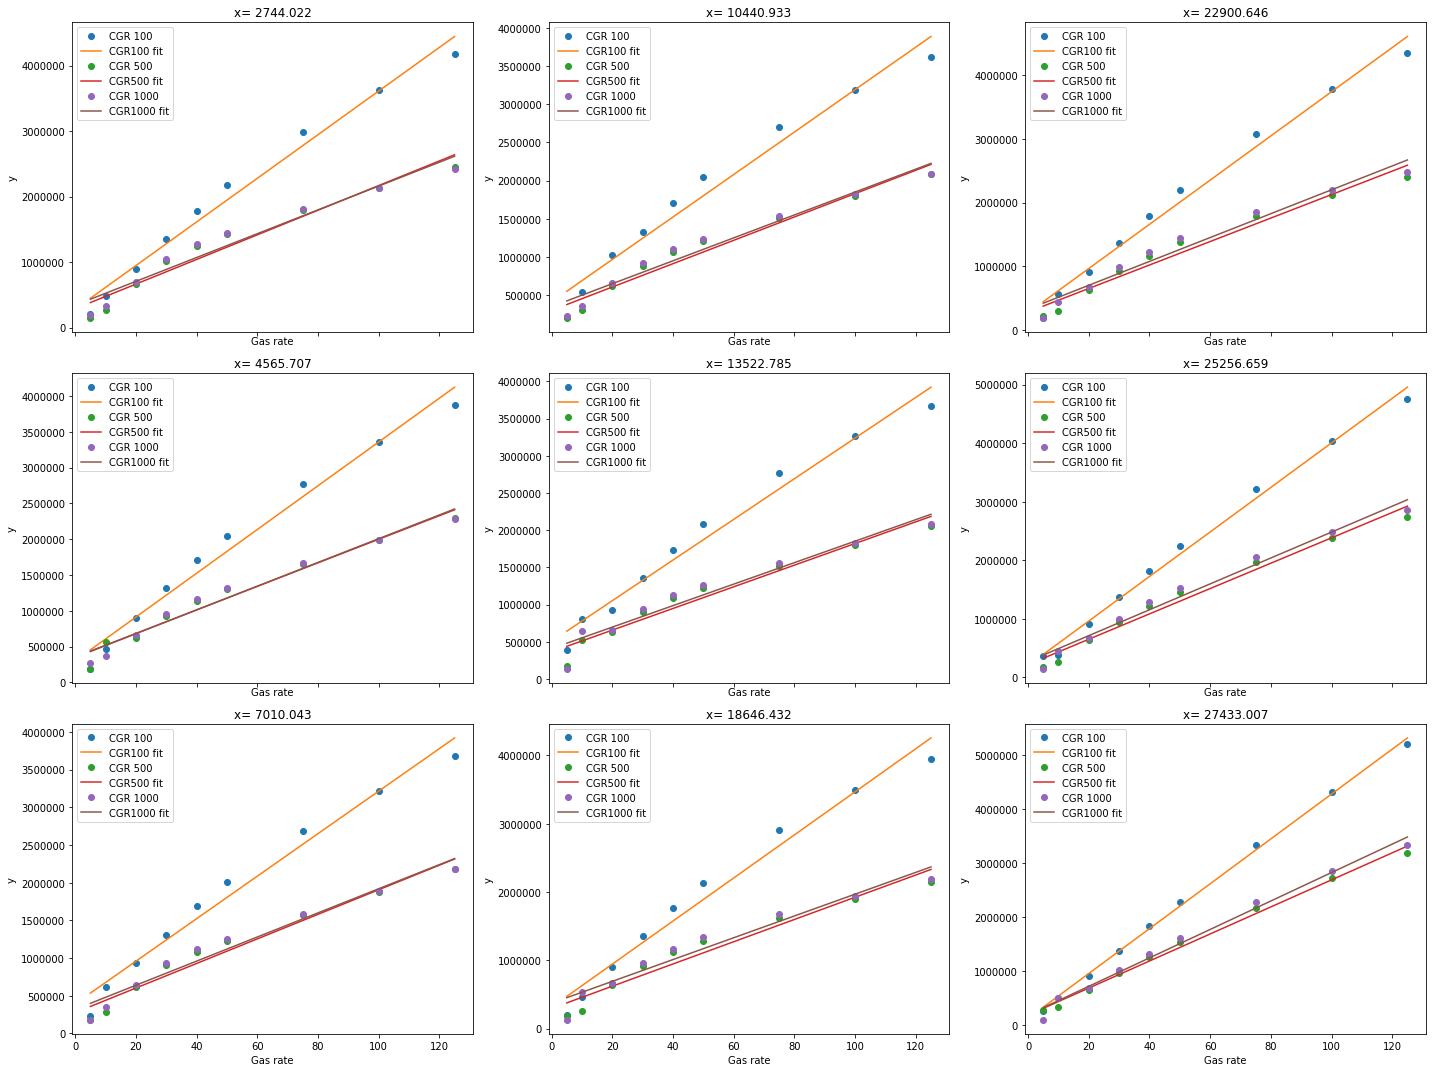

In [8]:
#Degree 1
plot_reg(reynolds,28,3,3,PolynomialModel(degree=1))

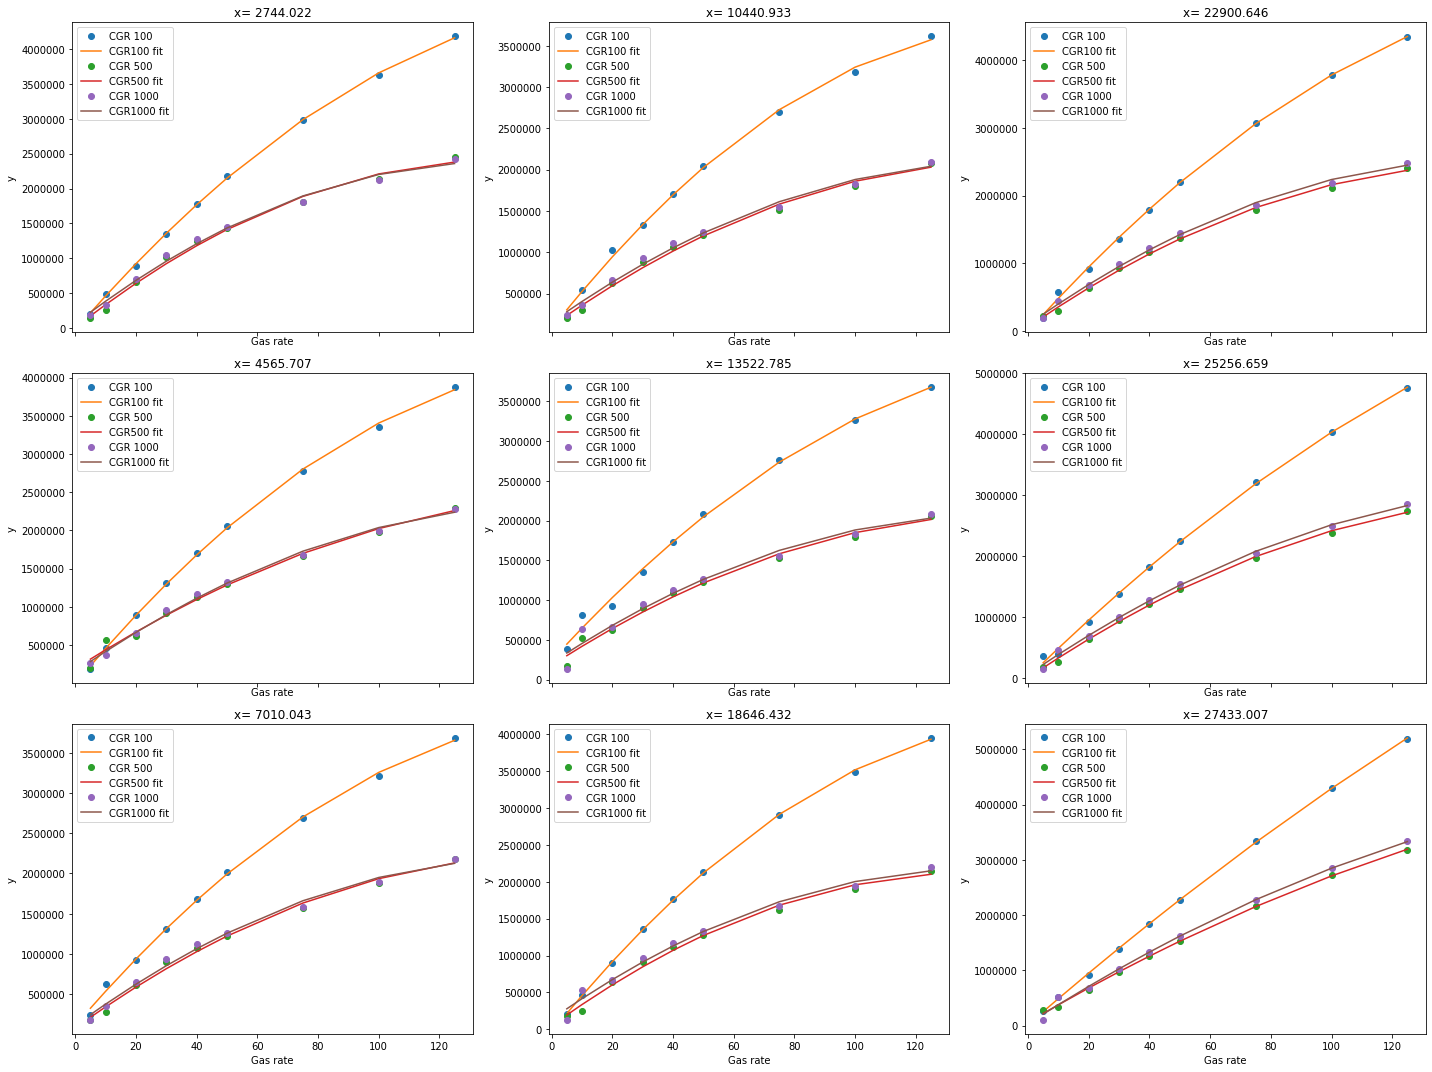

In [9]:
#Degree 2
ax=plot_reg(reynolds,28,3,3,PolynomialModel(degree=2))

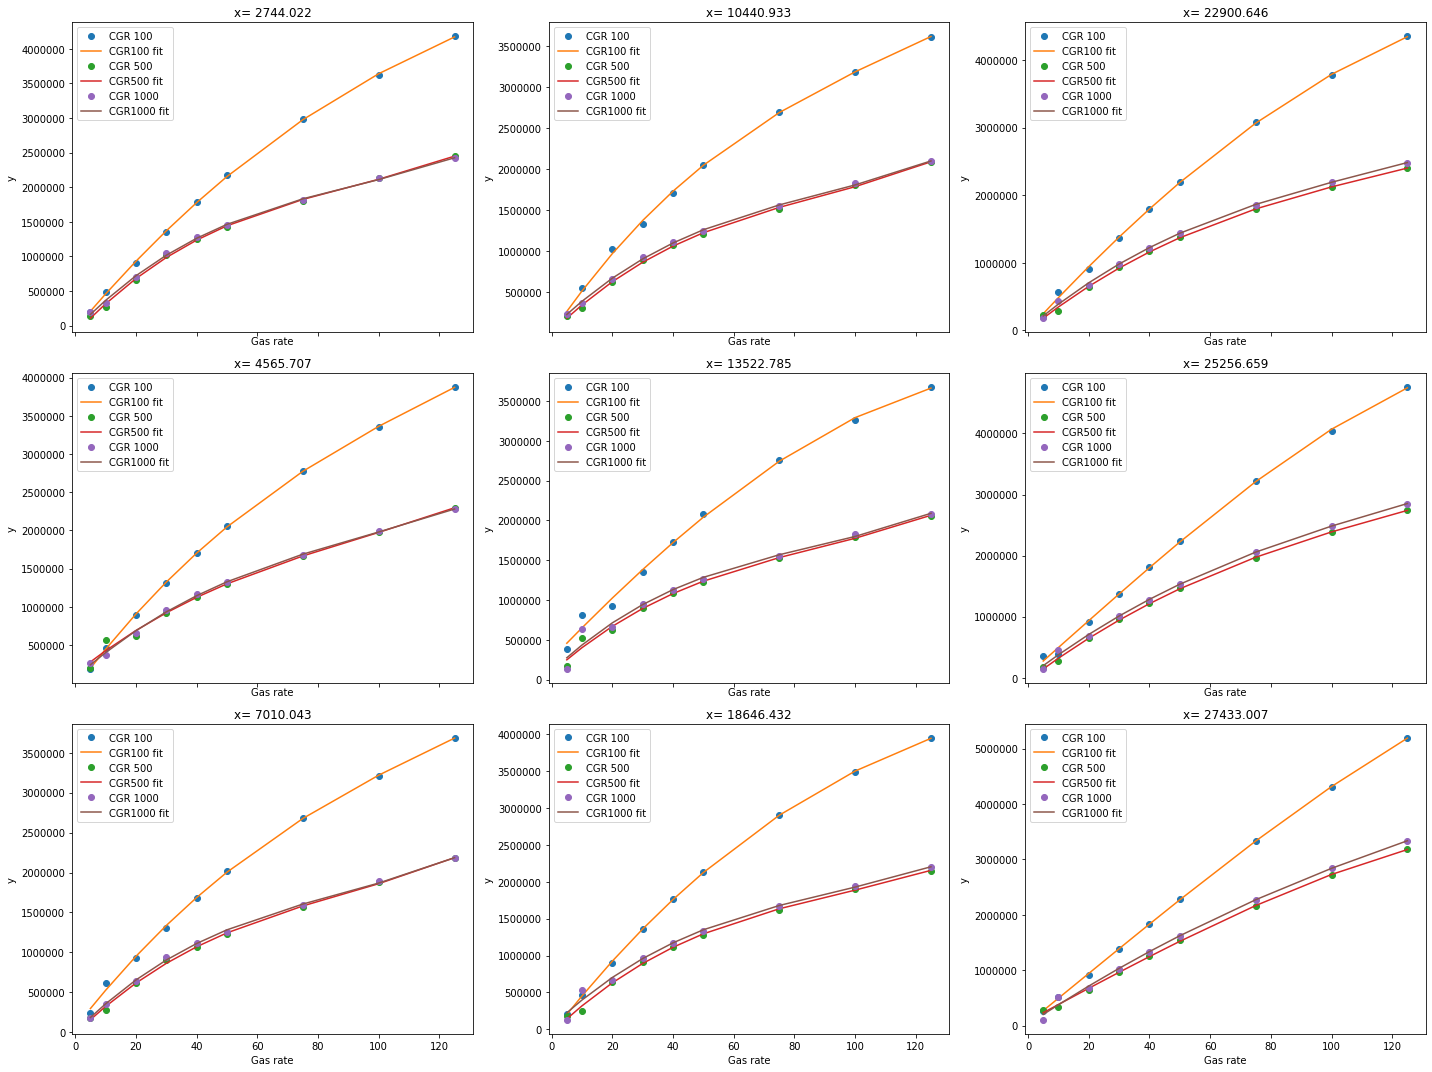

In [10]:
#Degree 3
plot_reg(reynolds,28,3,3,PolynomialModel(degree=3))

## Logarithmic 

/Users/nikoletta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/Users/nikoletta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


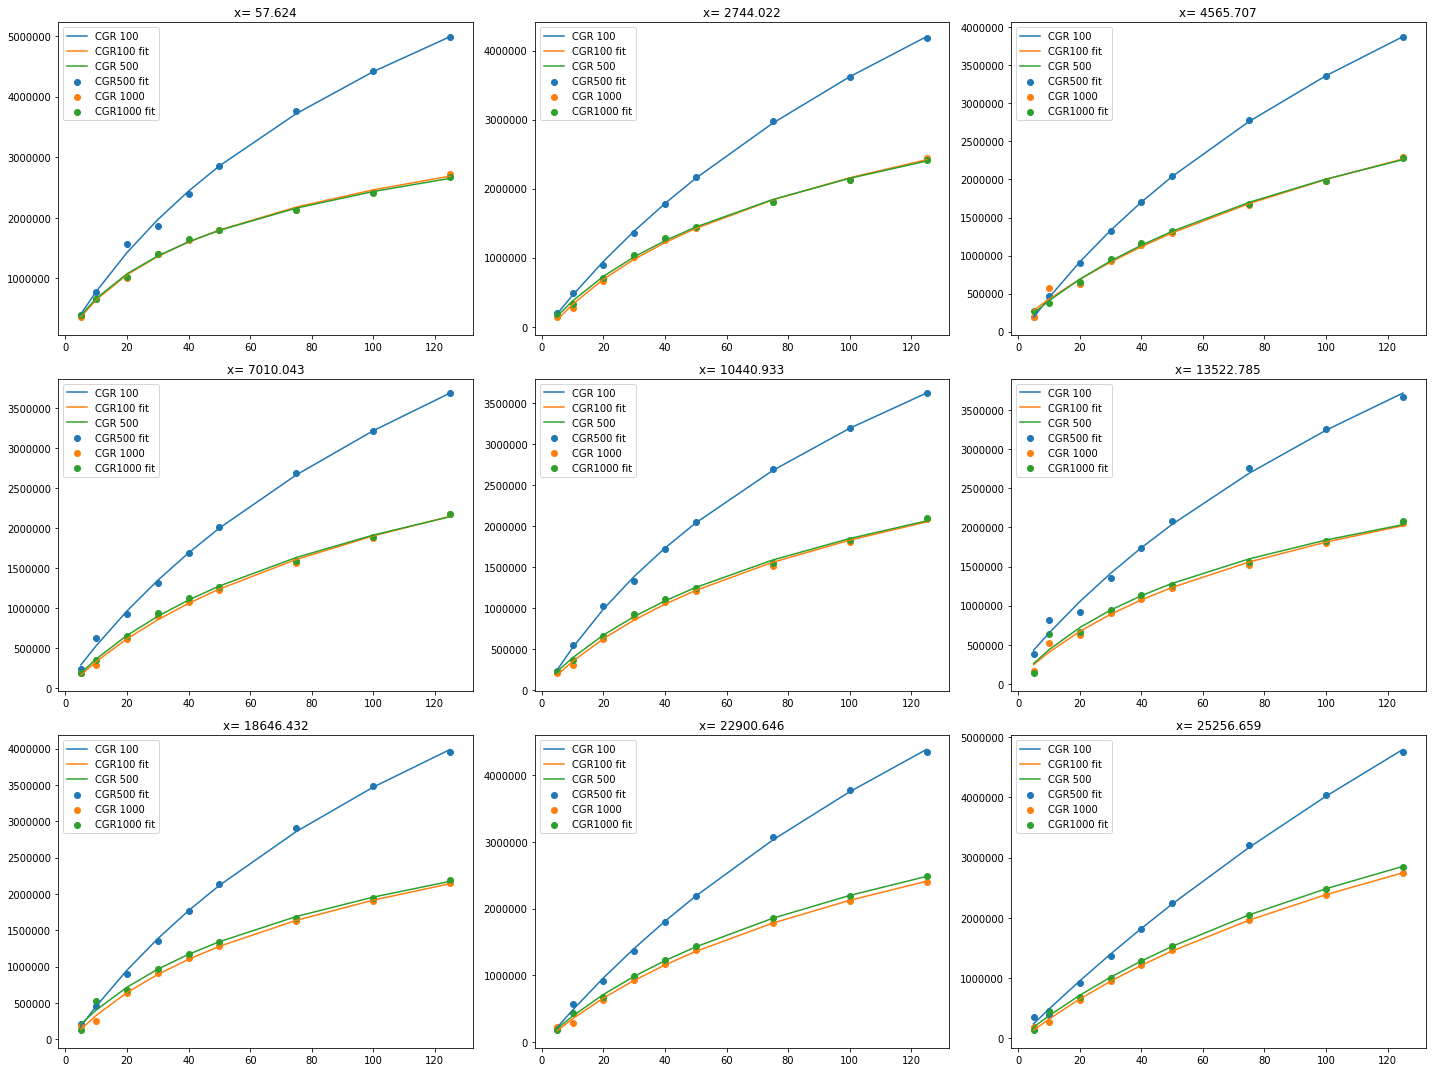

In [11]:
plot_logreg(reynolds,28, 3,3,log_fit)

## Power law

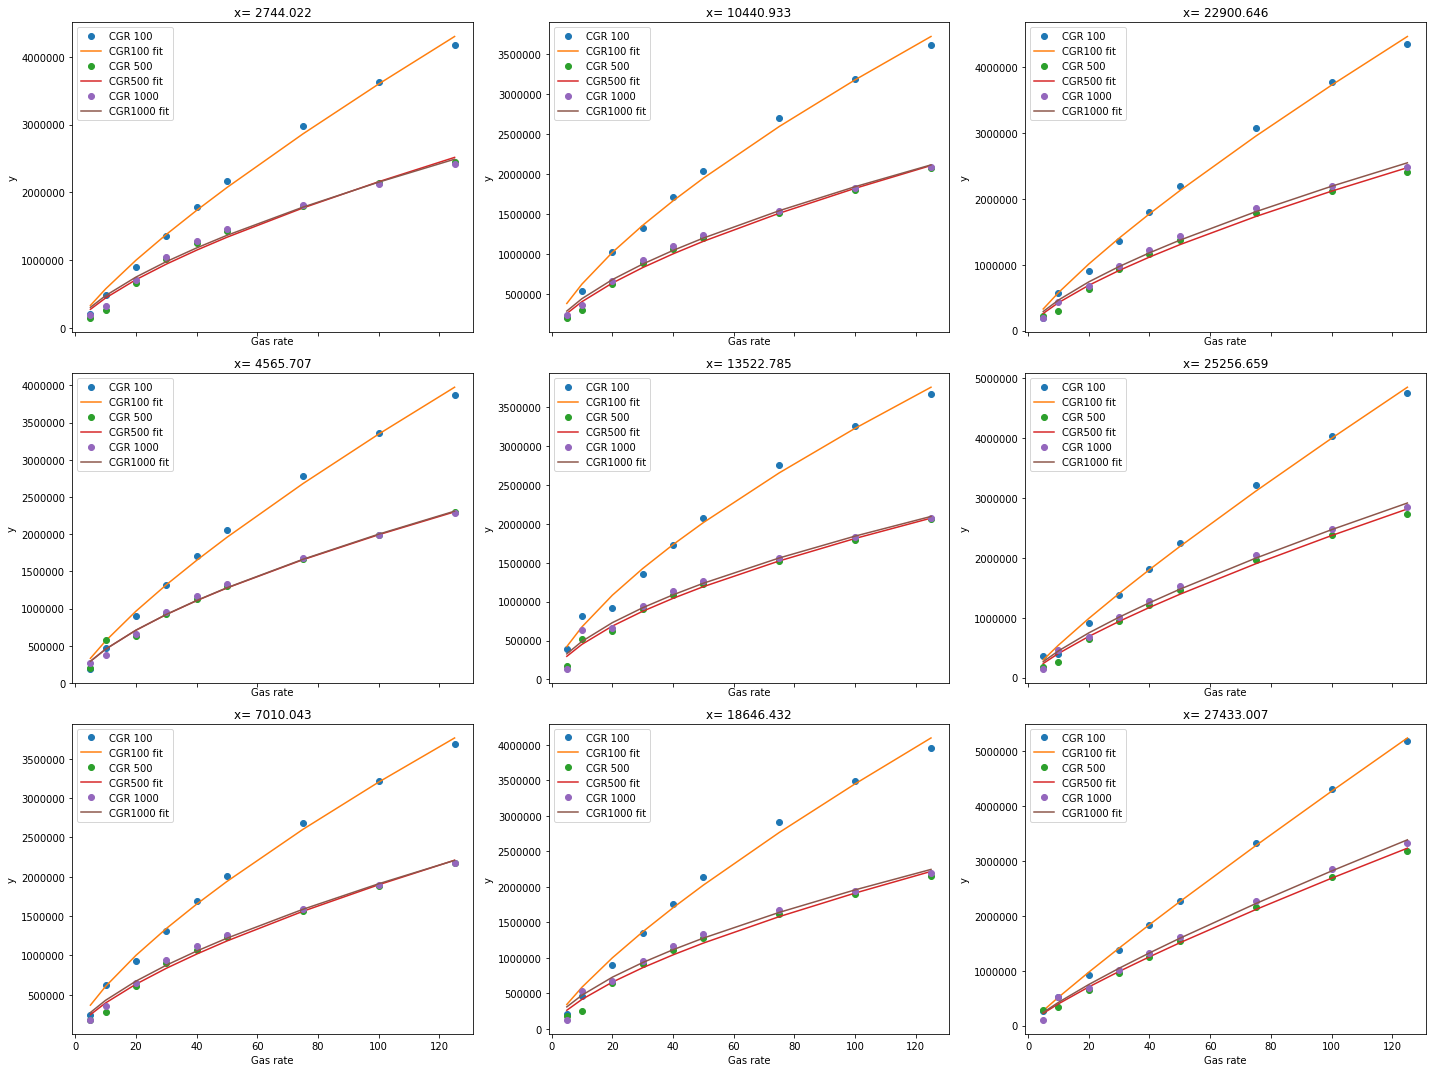

In [12]:
plot_reg(reynolds,28,3,3,PowerLawModel())

## Exponential 

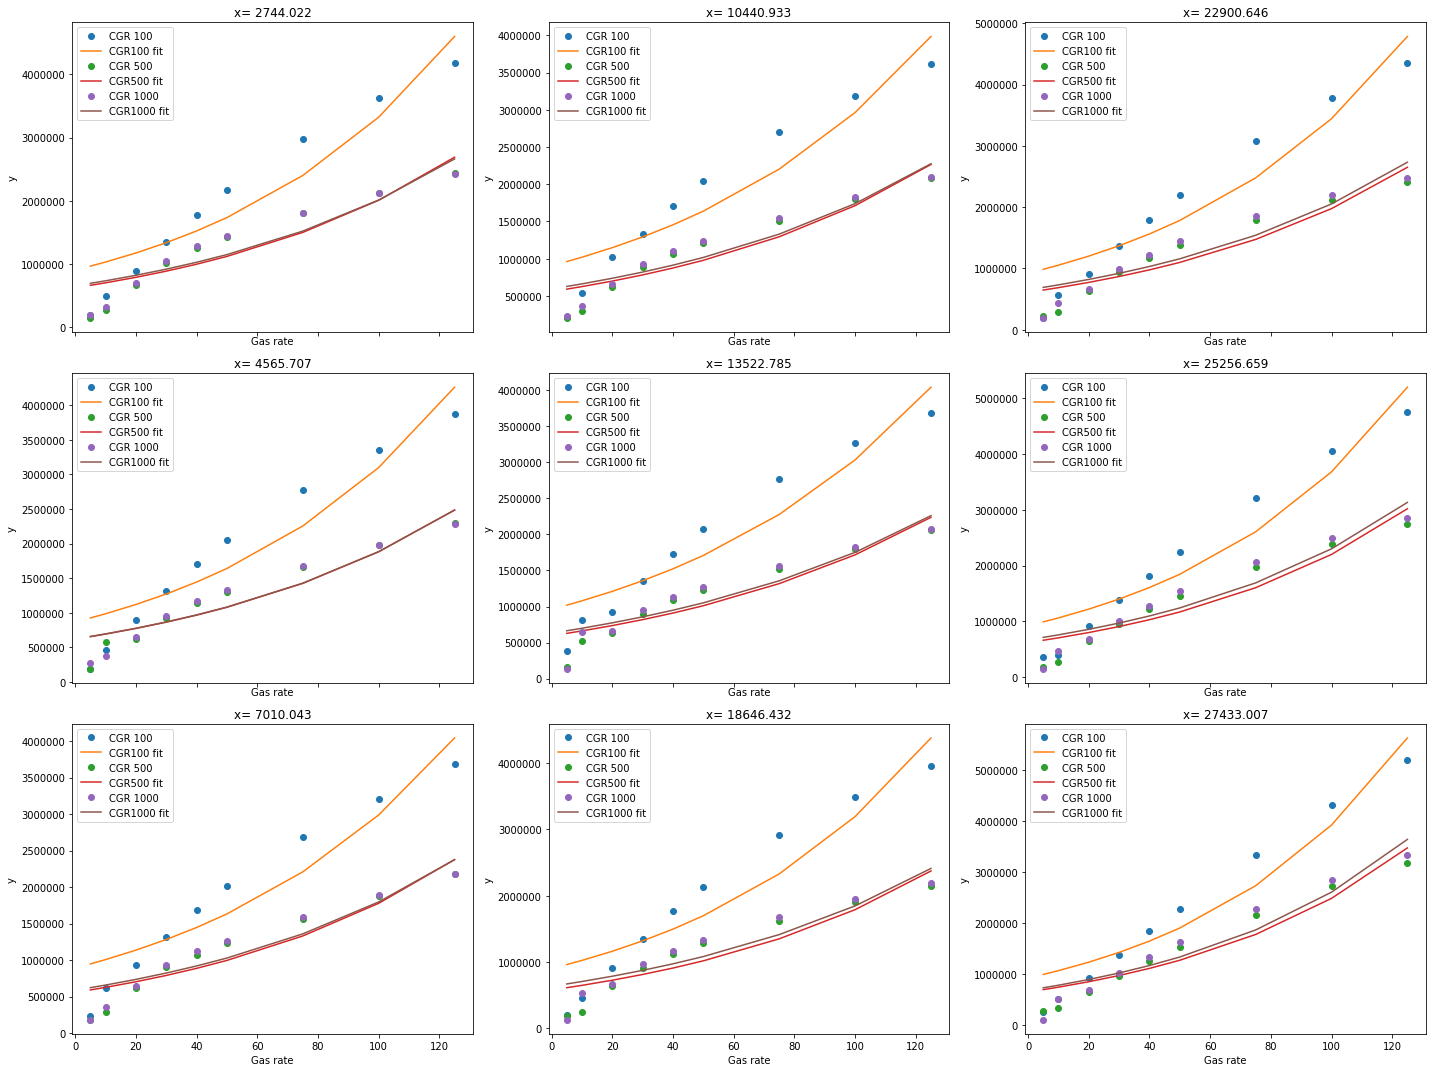

In [13]:
plot_reg(reynolds,28,3,3,ExponentialModel())

# Regression on Froude number 

## Polynomial 

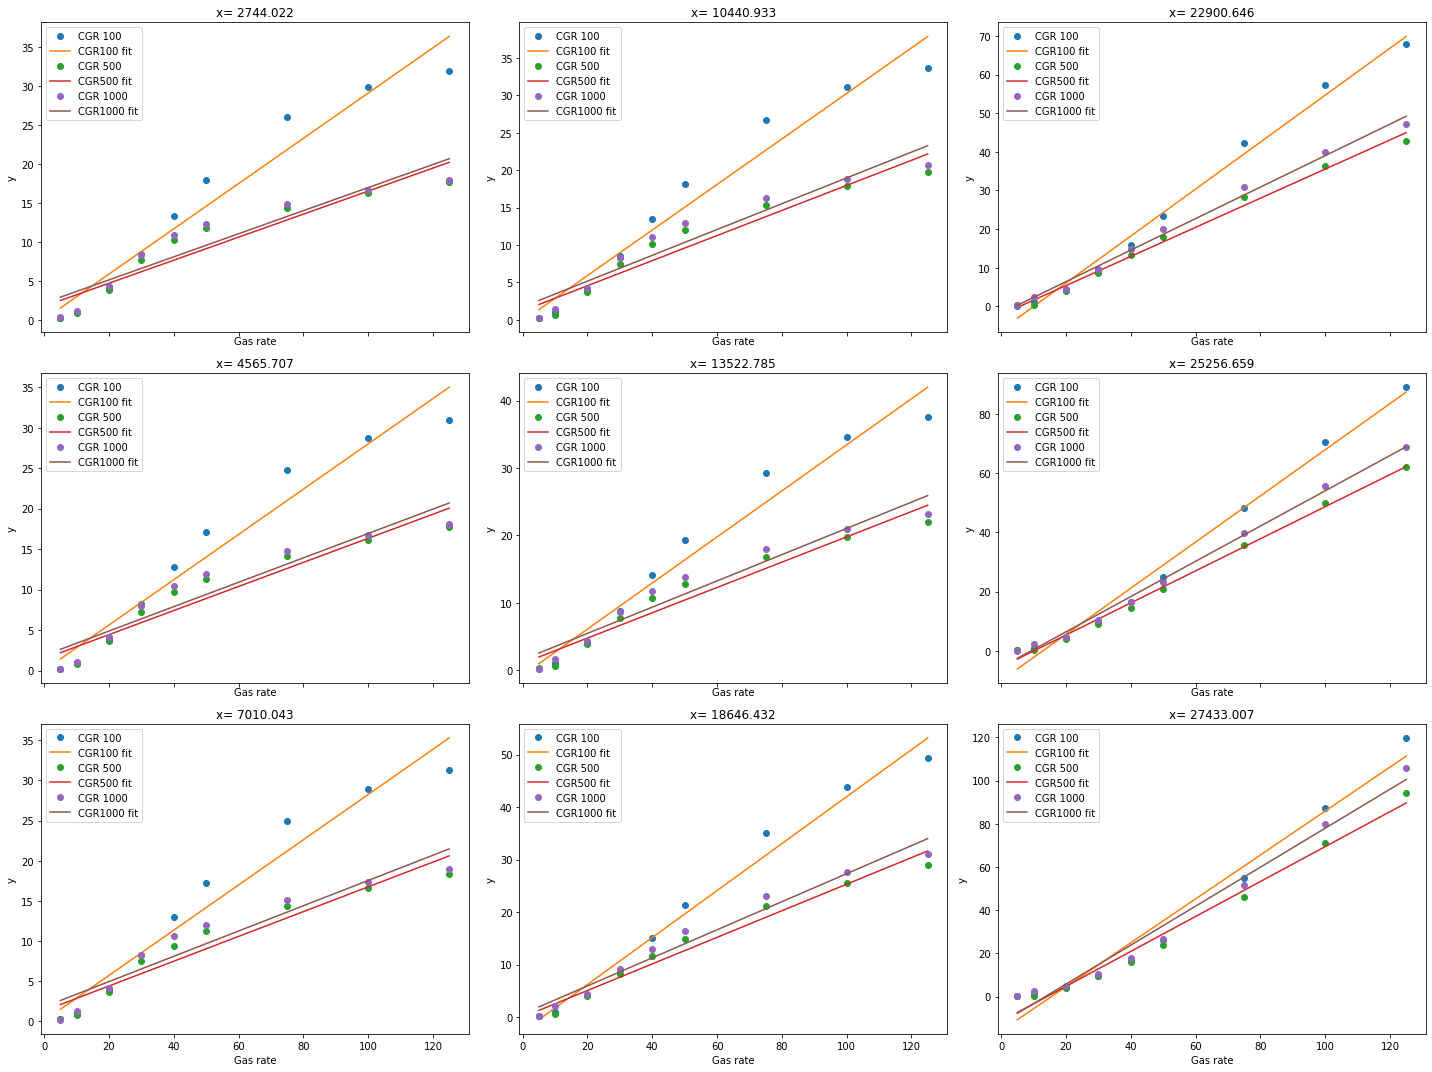

In [14]:
#Degree 1
plot_reg(froude,28,3,3,PolynomialModel(degree=1))


In [ ]:
#Degree 2
ax=plot_reg(froude,28,3,3,PolynomialModel(degree=2))
 

In [ ]:
#Degree 4
plot_reg(froude,28,3,3,PolynomialModel(degree=4))

## Logistic

In [ ]:
plot_reg(froude,28,3,3,StepModel(form='logistic'))

## Power law

In [ ]:
plot_reg(froude,28,3,3,PowerLawModel())

## Exponential   

In [ ]:
plot_reg(froude,28,3,3,ExponentialModel())

# Optional exercise 

Let's begin by identifying an appropriate regression function for the pressure, liquid and gas velocities.

In [ ]:
plot(pressure,28,3,3)
#Subplots of pressure

In [ ]:
#Subplots of gas velocity
plot(u_g,28,3,3)

In [ ]:
# Subplots of liquid velocity
plot(u_l,28,3,3)

In [ ]:
# fitting a function for pressure:
#A cubic or quadratic polynomial seems to capture the data well
plot_reg(pressure,28,3,3,PolynomialModel(degree=3))


In [ ]:
# fitting a function for gas velocity:
#A cubic or quadratic polynomial seems to capture the data well

plot_reg(u_g,28,3,3,PolynomialModel(degree=3))

In [ ]:
# fitting a function for liquid velocity:
#A linear model seems to capture the data well

plot_reg(u_l,28,3,3,PolynomialModel(degree=1))

Given the close proximity of the CGR500 and CGR1000 trends, a rough estimate of the three requested quantities could be a the average of of each quantity at CGR 500 and CGR1000. 


A more sophisticated approach, could be interpolating between the  trends to produce a trend for CGR600 like so:

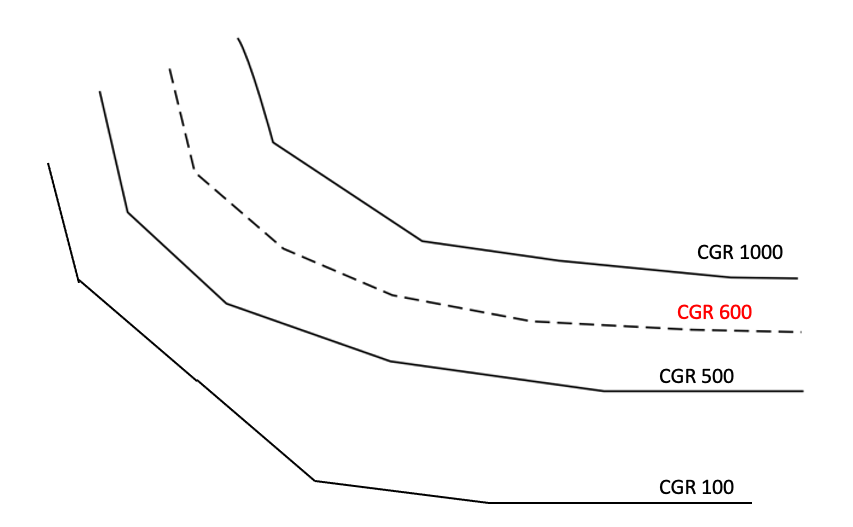